In [1]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.6 MB/s eta 0:00:00:00:0100:01


In [2]:
!uv pip install gym numpy matplotlib tqdm -q

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from tqdm import trange
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state),
                np.array(action),
                np.array(reward),
                np.array(next_state),
                np.array(done))

    def __len__(self):
        return len(self.buffer)


In [8]:
def train_dqn(env_name, episodes=500, gamma=0.99, lr=1e-3, batch_size=64,
              epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              target_update_freq=100, max_steps=500):

    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    q_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer = ReplayBuffer()
    epsilon = epsilon_start
    rewards_list = []

    for ep in trange(episodes, desc=f"DQN {env_name}"):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0

        for step in range(max_steps):
            # ε-greedy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = torch.argmax(q_net(s)).item()

            # Step
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Train
            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)

                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards).to(device)
                dones_t = torch.FloatTensor(dones).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)

                q_values = q_net(states_t).gather(1, actions_t).squeeze()
                next_q_values = target_net(next_states_t).max(1)[0]
                target = rewards_t + gamma * next_q_values * (1 - dones_t)

                loss = F.mse_loss(q_values, target.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        rewards_list.append(total_reward)

        # Target update
        if ep % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

    env.close()
    return rewards_list, q_net


## Mountain Car trying to go top a hill

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
DQN MountainCar-v0:   0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
DQN MountainCar-v0: 100%|██████████| 4000/4000 [28:30<00:00,  2.34it/s]


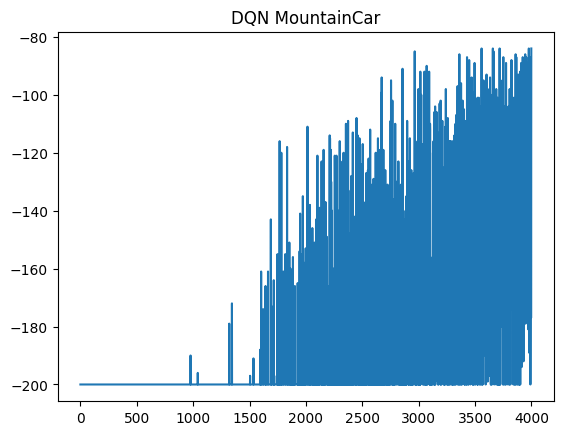

In [9]:
rewards_mc, model_mc = train_dqn(
    "MountainCar-v0", 
    episodes=4000,
    epsilon_decay=0.999
)
plt.plot(rewards_mc)
plt.title("DQN MountainCar"); plt.show()

In [14]:
def eval_agent(env_name, model, episodes=5, render=False, max_steps=1000):
    """
    Evaluate a trained DQN agent on the specified environment using GPU (if available).
    """
    model.eval()  # set to eval mode
    model = model.to(device)  # ensure model is on GPU

    env = gym.make(env_name)
    scores = []

    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0

        for t in range(max_steps):
            if render:
                env.render()

            with torch.no_grad():
                # Move state to GPU
                s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                # Forward pass entirely on GPU
                action = torch.argmax(model(s)).item()

            # Step in the environment
            step = env.step(action)
            if len(step) == 4:
                next_state, reward, done, _ = step
            else:
                next_state, reward, terminated, truncated, _ = step
                done = terminated or truncated

            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

    env.close()
    model.train()  # switch back to train mode
    return scores


In [15]:
print("MountainCar DQN Eval:", eval_agent("MountainCar-v0", model_mc))

MountainCar DQN Eval: [-97.0, -101.0, -113.0, -116.0, -113.0]


In [29]:
import imageio
import os
from tqdm import trange

def record_video(env_name, model, filename="dqn_animation.mp4",
                 max_steps=1000, fps=30, force_length=True):
    """
    Record a DQN agent video using GPU inference.
    - Uses GPU for model inference.
    - Can force a fixed video length even if episode terminates early.
    """
    env = gym.make(env_name)
    frames = []

    model = model.to(device)
    model.eval()

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    total_reward = 0.0
    done = False

    for step in trange(max_steps, desc=f"Recording {env_name}"):
        # Render frame (always append, even if done)
        frame = env.render(mode='rgb_array')
        frames.append(frame)

        # If episode ended but force_length=True → reset silently
        if done and force_length:
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            done = False

        # GPU inference
        with torch.no_grad():
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = torch.argmax(model(state_tensor)).item()

        step_result = env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated

        total_reward += reward
        state = next_state

        # If not forcing length, stop on done
        if done and not force_length:
            break

    env.close()

    # Save MP4
    output_path = os.path.join("/kaggle/working", filename)
    imageio.mimsave(output_path, frames, fps=fps)

    print(f"✅ Video saved to: {output_path}")
    print(f"🎯 Total reward (summed, not per-frame): {total_reward:.2f}")
    print(f"🎥 Total frames recorded: {len(frames)}")

    model.train()
    return output_path


In [35]:
mountain_video = record_video(
    "MountainCar-v0",
    model_mc,
    filename="mountaincar_video.mp4",
    max_steps=1000,
    force_length=True  # forces video to be full-length
)


Recording MountainCar-v0: 100%|██████████| 1000/1000 [00:03<00:00, 298.82it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved to: /kaggle/working/mountaincar_video.mp4
🎯 Total reward (summed, not per-frame): -1000.00
🎥 Total frames recorded: 1000


In [36]:
from IPython.display import Video

Video("mountaincar_video.mp4", embed=True)

##  Roulette

In [20]:
rewards_cp, model_cp = train_dqn(
    "CartPole-v1", 
    episodes=1
)

DQN CartPole-v1: 100%|██████████| 1/1 [00:00<00:00, 543.16it/s]


In [38]:
cartpole_video = record_video(
    "CartPole-v1",
    model_cp,
    filename="cartpole_video.mp4",
    max_steps=500,
    force_length=True
)

Recording CartPole-v1: 100%|██████████| 500/500 [00:01<00:00, 312.63it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved to: /kaggle/working/cartpole_video.mp4
🎯 Total reward (summed, not per-frame): 500.00
🎥 Total frames recorded: 500


In [39]:
Video("/kaggle/working/cartpole_video.mp4", embed=True)

In [40]:
rewards_cp, model_cp = train_dqn(
    "CartPole-v1", 
    episodes=500
)

DQN CartPole-v1: 100%|██████████| 500/500 [00:40<00:00, 12.21it/s]


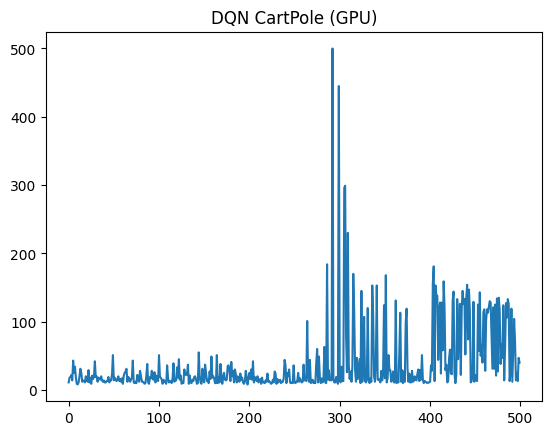

In [41]:
plt.plot(rewards_cp); plt.title("DQN CartPole (GPU)"); plt.show()

In [42]:
print("CartPole DQN (GPU) Evaluation:", eval_agent("CartPole-v1", model_cp, episodes=5))

CartPole DQN (GPU) Evaluation: [352.0, 224.0, 207.0, 333.0, 296.0]


In [43]:
cartpole_video = record_video(
    "CartPole-v1",
    model_cp,
    filename="cartpole_video.mp4",
    max_steps=500,
    force_length=True
)

Recording CartPole-v1: 100%|██████████| 500/500 [00:01<00:00, 339.82it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Video saved to: /kaggle/working/cartpole_video.mp4
🎯 Total reward (summed, not per-frame): 500.00
🎥 Total frames recorded: 500


In [44]:
Video("/kaggle/working/cartpole_video.mp4", embed=True)